#1 실습 문제 

사용할 데이터 : house.csv

네이버 부동산에서 크롤링해 가져온 서울시 부동산 데이터

* Unnamed: 0 : 의미없는 칼럼
* id : 매물id
> 한 매물당 하나의 id가 할당된다.
* lat : 위도
* lng : 경도
* gu : 구(행정지역정보)
* goodsType : 매물의 거래형태(아파트,빌라 등)
* payType : 판매의 거래형태(월세,매매 등)
* floor : 매물방의 층수
* floor_total : 매물이 있는 전체 건물의 층수
* contractArea : 계약면적
* realArea : 실제면적
* direction : 창문방향(남향,북향)
* tag : 매물마다 관련된 설명정보
> ex. 일조량 및 관리 잘 된 복층
* tagList : 매물마다 관련된 설명에서의 태그
> ex. '10년이내, 25년이내 건축, 복층'과 같이 인스타 해시테그 느낌
* deposit : 보증금
* monthlyPay : 월세


> 데이터 출처 : 네이버 부동산 크롤링 데이터

설명
* X와 y를 찾아, LinearRegression을 위 예제1을 참고하여 실행하시오.
* 예를 들면, y='보증금', X=나머지 으로 하여 나머지 값으로 보증금을 예측하는 선형회귀문제로 Task를 정해 코딩을 진행

* 조건
> * ***(핵심내용)*** X & y로 이용할 것을 명확히 제시하고, y에 따른 어떤 문제인지 파악하기 -> OK
>    * y를 연속형으로 하여, LinearRegression문제가 될 수 있도록 한다. -> OK
> * X변수에 1개이상의 범주형데이터를 포함하고, one-hot encoding을 사용하기 -> OK
> * 최소 1가지 이상의 방법으로 X데이터 중 1개 이상의 열을 삭제하기 -> OK
> * 데이터 분할 진행하기 -> OK
> * ***(핵심내용)*** 다중선형회귀 모델을 사용하기 -> OK
> * 규제항이 있는 모델(Ridge,Lasso)을 사용하기 -> OK
> * hyper-parameter 튜닝을 진행하기 -> OK
>   * cross_val_score를 사용하지 않아도 됩니다. 
>   * GridSearchCV ,RandomSearchCV을 사용하셔도 됩니다.
>   * 참고자료 : https://dacon.io/codeshare/
> * ***(핵심내용)*** 변수 중요도 해석
>   * 스케일링 없이 -> OK
>   * min-max scaling -> OK
>   * standard scaling -> OK

##라이브러리 및 데이터 임포트

In [ ]:
# 기본적인 라이브러리(기초세션에서 다룸)
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 임포트

data = pd.read_csv('/content/drive/MyDrive/DSL/2023-1 과제/[0131][HW]_LinearRegression_and_SVM/data/house.csv') 

#불필요한 unnamed 칼럼, id칼럼 삭제, 다루기 까다로운 tag, taglist 삭제
data = data.drop(columns = ['Unnamed: 0', 'id', 'tagList', 'tag'])

#부동산의 층수는 중요하지만, 부동산 전체의 층수는 중요하지 않을 것으로 보고 삭제
data = data.drop(columns = 'floor_total')

data.head(5)

,lat,lng,gu,goodsType,payType,floor,contractArea,realArea,direction,deposit,monthlyPay
0,37.677967,127.041725,dobong,아파트,매매,5,81,63,남향,63000,0
1,37.657623,127.044115,dobong,아파트,매매,15,154,119,남향,140000,0
2,37.645001,127.040034,dobong,빌라,전세,3,38,33,남향,15000,0
3,37.666850,127.039420,dobong,아파트,매매,5,107,84,남향,60000,0
4,37.655622,127.041475,dobong,사무실,월세,2,30,22,북향,700,44


In [ ]:
#매매 타입의 부동산만 분석해보기.

data = data[data['payType'] == '매매']
data = data.drop(columns = ['payType', 'monthlyPay'])
data

,lat,lng,gu,goodsType,floor,contractArea,realArea,direction,deposit
0,37.677967,127.041725,dobong,아파트,5,81,63,남향,63000
1,37.657623,127.044115,dobong,아파트,15,154,119,남향,140000
3,37.666850,127.039420,dobong,아파트,5,107,84,남향,60000
5,37.664549,127.045942,dobong,아파트,16,122,84,남향,98000
6,37.648835,127.034307,dobong,빌라,3,41,35,서향,20000
...,...,...,...,...,...,...,...,...,...
93971,37.482110,127.063507,gangnam,아파트,19,134,99,남동향,365000
93984,37.485730,127.049990,gangnam,아파트,7,151,126,남향,350000
93986,37.502378,127.046890,gangnam,아파트,19,117,92,남향,300000
93987,37.514753,127.038152,gangnam,빌라,8,218,180,남향,480000


##결측치와 이상치 찾기

In [ ]:
#direction은 결측치를 대체할 합리적인 방법을 찾기 어려우므로, 결측치가 존재하는 행은 삭제

data = data.dropna()
print(data.isna().sum())

lat             0
lng             0
gu              0
goodsType       0
floor           0
contractArea    0
realArea        0
direction       0
deposit         0
dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f32053b19a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32053ba0a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32053b1610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32053ba760>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32053baa60>],
 'means': []}

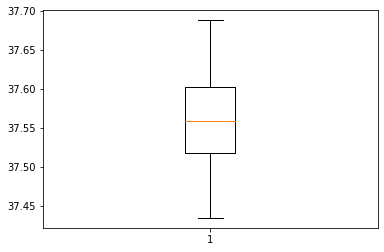

In [ ]:
#위도는 아웃라이어 없음

plt.boxplot(data['lat'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3205458b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3205457280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3205458820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3205457940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3205457c40>],
 'means': []}

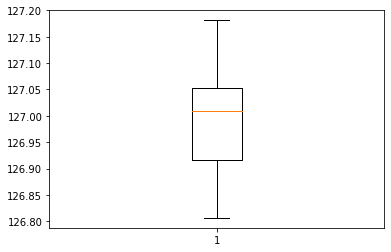

In [ ]:
#경도는 아웃라이어 없음

plt.boxplot(data['lng'])

20.5
1038


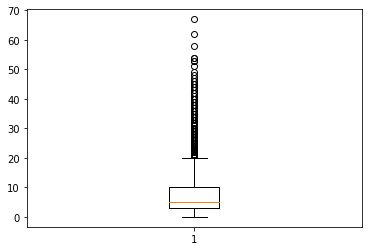

In [ ]:
#층수는 아웃라이어 1038개 존재. 전체 행수가 3만개 정도이므로 3% 정도의 아웃라이어는 삭제

plt.boxplot(data['floor'])
print(np.quantile(data['floor'], 0.75) + 1.5 * (np.quantile(data['floor'], 0.75) - np.quantile(data['floor'], 0.25)))
print(len(data[data['floor'] >= 20.5]))
data = data.drop(data[data['floor'] >= 20.5].index)

187.0
944


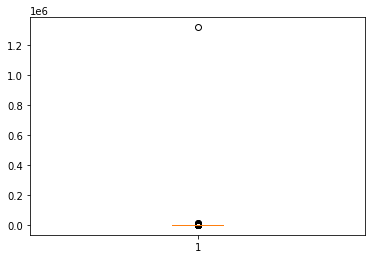

In [ ]:
#계약면적은 아웃라이어 959개 존재. 전체 행수가 3만개 정도이므로 3% 정도의 아웃라이어는 삭제

plt.boxplot(data['contractArea'])
print(np.quantile(data['contractArea'], 0.75) + 1.5 * (np.quantile(data['contractArea'], 0.75) - np.quantile(data['contractArea'], 0.25)))
print(len(data[data['contractArea'] >= 187.0]))
data = data.drop(data[data['contractArea'] >= 187.0].index)

148.5
121


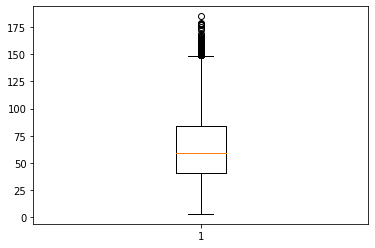

In [ ]:
#계약면적은 아웃라이어 121개 존재. 전체 행수가 3만개 정도이므로 0.3% 정도의 아웃라이어는 삭제

plt.boxplot(data['realArea'])
print(np.quantile(data['realArea'], 0.75) + 1.5 * (np.quantile(data['realArea'], 0.75) - np.quantile(data['realArea'], 0.25)))
print(len(data[data['realArea'] >= 148.5]))
data = data.drop(data[data['realArea'] >= 148.5].index)

228217.0
729


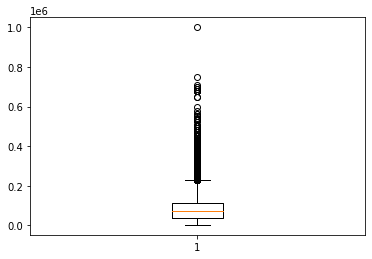

In [ ]:
#매매대금은 아웃라이어 729개 존재. 전체 행수가 3만개 정도이므로 2% 정도의 아웃라이어는 삭제

plt.boxplot(data['deposit'])
print(np.quantile(data['deposit'], 0.75) + 1.5 * (np.quantile(data['deposit'], 0.75) - np.quantile(data['deposit'], 0.25)))
print(len(data[data['deposit'] >= 228217.0]))
data = data.drop(data[data['deposit'] >= 228217.0].index)

In [ ]:
#이상치와 결측치가 모두 제거되고 남은 27433개의 행을 가지고 분석 실시

len(data)

27433

##기술분석을 통한 독립변수 추리기
y 변수는 가장 자연스러운 연속변수인 deposit으로 하고, deposit과 관련성이 있어보이는 독립변수들만 뽑아보기

In [ ]:
#상관계수가 3% 미만인 경도 칼럼 삭제
#그 외 연속변수들은 상관관계가 유의미해보임

print(data.corr())
data = data.drop(columns = 'lng')

                   lat       lng     floor  contractArea  realArea   deposit
lat           1.000000  0.365504 -0.024281     -0.030563  0.004058 -0.195099
lng           0.365504  1.000000  0.004557     -0.031464 -0.017283  0.039295
floor        -0.024281  0.004557  1.000000      0.245863  0.204986  0.299350
contractArea -0.030563 -0.031464  0.245863      1.000000  0.935610  0.699739
realArea      0.004058 -0.017283  0.204986      0.935610  1.000000  0.707631
deposit      -0.195099  0.039295  0.299350      0.699739  0.707631  1.000000


In [ ]:
#계약면적과 실제면적 간의 상관계수가 0.9 이상이므로 다중공선성 문제가 의심됨. 계약면적 칼럼을 제거
data = data.drop(columns = 'contractArea')

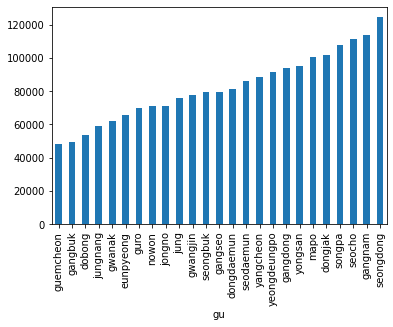

In [ ]:
data.groupby('gu')['deposit'].mean().sort_values().plot(kind = 'bar')

In [ ]:
data.groupby('goodsType')['deposit'].mean().sort_values()

goodsType
상가주택        24666.666667
오피스텔        34800.955259
빌라          42778.503774
사무실         47567.518519
오피스텔분양권     61857.947917
상가          65850.378136
단독/다가구      72777.049180
아파트        104972.290998
아파트분양권     122080.729167
재건축        152671.641791
Name: deposit, dtype: float64

In [ ]:
data.groupby('direction')['deposit'].mean().sort_values()

direction
북향     44752.191941
북서향    51955.415254
북동향    54207.649733
서향     56568.798344
동향     70335.529638
남향     85582.821343
남동향    86907.747569
남서향    88208.700441
Name: deposit, dtype: float64

In [ ]:
#디렉션 칼럼의 범주가 너무 많으므로, 동서남북의 네 가지 칼럼으로만 구분

temp = [x[0] for x in data['direction']]
data['direction'] = temp
data.head(10)

,lat,gu,goodsType,floor,realArea,direction,deposit
0,37.677967,dobong,아파트,5,63,남,63000
1,37.657623,dobong,아파트,15,119,남,140000
3,37.666850,dobong,아파트,5,84,남,60000
5,37.664549,dobong,아파트,16,84,남,98000
6,37.648835,dobong,빌라,3,35,서,20000
8,37.682577,dobong,오피스텔,3,18,남,11500
10,37.659074,dobong,아파트,13,119,남,139000
11,37.655965,dobong,아파트,12,59,동,65000
14,37.659568,dobong,빌라,2,43,남,34000
16,37.652374,dobong,빌라,2,49,남,20000


##범주형 변수 원핫인코딩
범주형 변수인 지역구, 매물타입, 방향은 모두 deposit과 상관이 높아보임.
이 변수들을 모두 원 핫 인코딩

In [ ]:
temp = pd.get_dummies(data.loc[:,'gu'])
temp.columns = ['gu1', 'gu2', 'gu3', 'gu4', 'gu5', 'gu6', 'gu7', 'gu8', 'gu9', 'gu10', 'gu11', 'gu12', 'gu13', 'gu14', 'gu15', 'gu16', 'gu17', 'gu18', 'gu19', 'gu20', 'gu21', 'gu22', 'gu23', 'gu24', 'gu25',]
temp
data = data.drop(['gu'], axis=1)
data = pd.concat([data, temp], axis=1)

In [ ]:
temp = pd.get_dummies(data.loc[:,'goodsType'])
temp.columns = ['type1', 'type2', 'type3', 'type4', 'type5', 'type6', 'type7', 'type8', 'type9', 'type10']
data = data.drop(['goodsType'], axis=1)
data = pd.concat([data, temp], axis=1)

In [ ]:
temp = pd.get_dummies(data.loc[:,'direction'])
temp
temp.columns = ['direction1', 'direction2', 'direction3', 'direction4']
data = data.drop(['direction'], axis=1)
data = pd.concat([data, temp], axis=1)
data.head(5)

,lat,floor,realArea,deposit,gu1,gu2,gu3,gu4,gu5,gu6,...,type5,type6,type7,type8,type9,type10,direction1,direction2,direction3,direction4
0,37.677967,5,63,63000,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,37.657623,15,119,140000,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,37.666850,5,84,60000,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,37.664549,16,84,98000,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
6,37.648835,3,35,20000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##데이터셋 분리

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data.drop(columns = 'deposit'), data['deposit'], train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(21946, 42) (5487, 42) (21946,) (5487,)


In [ ]:
#OLS 선형회귀를 통해 1차적으로 독립변수들의 영향력을 검정
#train set에 대해서만 실시
#결과적으로 의미없는 변수들은 없다고 나옴

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_constant = sm.add_constant(train_X, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(train_y, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1630.
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:03:43   Log-Likelihood:            -2.5269e+05
No. Observations:               21946   AIC:                         5.055e+05
Df Residuals:                   21906   BIC:                         5.058e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.952e+06   3.74e+05     13.241      0.000    4.22e+06    5.69e+06
lat        -1.828e+05   1.38e+04    -13.202      0.000    -2.1e+05   -1.56e+05
floor        605.2522     39.090     15.484      0.000     528.633     681.871
realArea     903.4711      7.655    118.028      0.000     888.467     918.475
gu1         1.892e+05   1.64e+04     11.506      0.000    1.57e+05    2.21e+05
gu2         1.953e+05   1.53e+04     12.737      0.000    1.65e+05    2.25e+05
gu3         1.955e+05   1.42e+04     13.735      0.000    1.68e+05    2.23e+05
gu4          1.94e+05   1.57e+04     12.319      0.000    1.63e+05    2.25e+05
gu5         1.877e+05   1.61e+04     11.666      0.000    1.56e+05    2.19e+05
gu6         2.055e+05   1.49e+04     13.773      0.000    1.76e+05    2.35e+05
gu7         2.346e+05   1.43e+04     16.423      0.000    2.07e+05    2.63e+05
gu8          1.95e+05   1.51e+04     12.943      0.000    1.65e+05    2.24e+05
gu9         1.626e+05   1.37e+04     11.845      0.000    1.36e+05    1.89e+05
gu10        1.667e+05   1.42e+04     11.745      0.000    1.39e+05    1.94e+05
gu11        1.652e+05    1.4e+04     11.804      0.000    1.38e+05    1.93e+05
gu12        2.044e+05   1.49e+04     13.718      0.000    1.75e+05    2.34e+05
gu13         2.02e+05   1.54e+04     13.118      0.000    1.72e+05    2.32e+05
gu14        2.008e+05   1.51e+04     13.283      0.000    1.71e+05     2.3e+05
gu15        1.893e+05   1.56e+04     12.147      0.000    1.59e+05     2.2e+05
gu16        2.156e+05    1.5e+04     14.371      0.000    1.86e+05    2.45e+05
gu17        1.905e+05   1.63e+04     11.691      0.000    1.59e+05    2.22e+05
gu18        2.269e+05   1.41e+04     16.091      0.000    1.99e+05    2.55e+05
gu19        1.953e+05   1.53e+04     12.736      0.000    1.65e+05    2.25e+05
gu20          1.9e+05   1.57e+04     12.101      0.000    1.59e+05    2.21e+05
gu21        2.235e+05    1.5e+04     14.869      0.000    1.94e+05    2.53e+05
gu22        2.121e+05   1.42e+04     14.901      0.000    1.84e+05     2.4e+05
gu23        1.901e+05   1.46e+04     13.020      0.000    1.62e+05    2.19e+05
gu24        1.945e+05   1.45e+04     13.401      0.000    1.66e+05    2.23e+05
gu25        2.256e+05   1.48e+04     15.274      0.000    1.97e+05    2.55e+05
type1       4.985e+05   3.76e+04     13.253      0.000    4.25e+05    5.72e+05
type2       4.791e+05   3.75e+04     12.790      0.000    4.06e+05    5.53e+05
type3       4.718e+05   3.75e+04     12.595      0.000    3.98e+05    5.45e+05
type4       4.988e+05   3.74e+04     13.320      0.000    4.25e+05    5.72e+05
type5       4.534e+05   4.05e+04     11.196      0.000    3.74e+05    5.33e+05
type6       5.111e+05   3.74e+04     13.651      0.000    4.38e+05    5.84e+05
type7       5.323e+05   3.76e+04     14.165      0.000    4.59e+05    6.06e+05
ty

##다중선형회귀 및 성능평가

In [ ]:
# 회귀(y값이 연속형변수)의 평가지표

from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    # MSE는 제곱이기에 값이 큼으로 r-MSE(root)를 이용한다.
    # MSE는 scikit-learn의 mean_squared_error()로 계산
    rmse_val = np.sqrt(mean_squared_error(y,pred))
    # MAE는 scikit-learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)

    # (r-MSE & MAE)를 출력 후, 반환해주는 함수
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))
    return (rmse_val, mae_val)

RMSE: 24132.451, MAE: 18138.517


<BarContainer object of 2 artists>

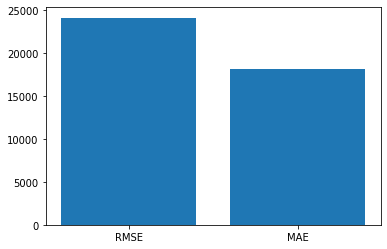

In [ ]:
#규제항과 스케일링 없이 실시

from sklearn.linear_model import LinearRegression

# Model
lr_model = LinearRegression()
lr_model.fit(train_X, train_y) # 최적화식을 풀어 학습파라미티(회귀계수)를 구한다.
pred = lr_model.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

##규제항을 포함한 다중회귀분석

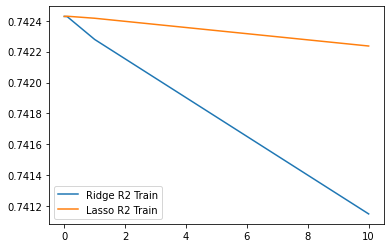

In [ ]:
# 모델 검증에 사용되는 라이브러리
from sklearn.model_selection import cross_val_score

# 규제항이 있는 선형회귀 관련 라이브러리
from sklearn.linear_model import Ridge, Lasso

# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]

# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

import warnings
warnings.filterwarnings('ignore')

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)

    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [ ]:
# 각각 alpha = 0.001, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=0.001) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=0.001)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# RMSE; mean_squared_error
print("RMSE for Ridge model : {:.5f}".format(np.sqrt(mean_squared_error(test_y, ridge.predict(test_X)))))
print("RMSE for Lasso model : {:.5f}".format(np.sqrt(mean_squared_error(test_y, lasso.predict(test_X)))))

R square score for Ridge model : 0.74507
R square score for Lasso model : 0.74507
RMSE for Ridge model : 24132.43852
RMSE for Lasso model : 24132.44658


RMSE: 24132.439, MAE: 18138.513


<BarContainer object of 2 artists>

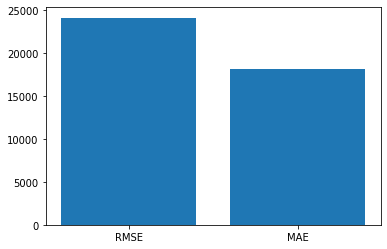

In [ ]:
pred = ridge.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

RMSE: 24132.447, MAE: 18138.513


<BarContainer object of 2 artists>

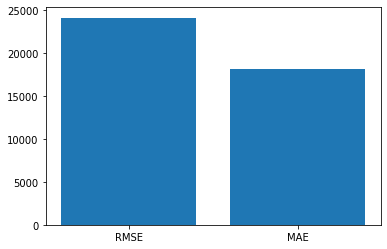

In [ ]:
pred = lasso.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

규제항을 포함했으나 큰 차이가 없음 <br>
왜냐면 모든 변수들이 다 유의미하기 때문

##변수 중요도 해석

###원 단위

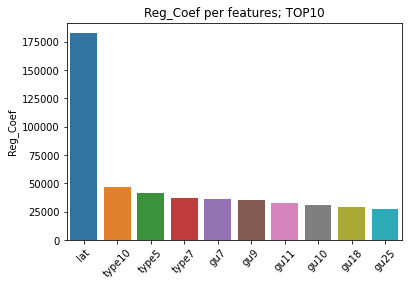

In [ ]:
# 원 회귀계수의 절댓값
coef = ridge.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = data.drop(columns = 'deposit').head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

###minmax 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

total_data = data.iloc[:, :4]

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df = pd.concat([trans_data_df.reset_index(drop=True), data.iloc[:, 4:].reset_index(drop=True)], axis = 1)
trans_data_df # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,lat,floor,realArea,deposit,gu1,gu2,gu3,gu4,gu5,gu6,...,type5,type6,type7,type8,type9,type10,direction1,direction2,direction3,direction4
0,0.960933,0.25,0.413793,0.266992,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.880741,0.75,0.800000,0.609063,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.917112,0.25,0.558621,0.253665,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0.908042,0.80,0.558621,0.422479,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0.846101,0.15,0.220690,0.075966,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27428,0.325501,0.10,0.255172,0.875611,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
27429,0.312982,0.25,0.165517,0.155931,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
27430,0.223641,0.05,0.131034,0.475789,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27431,0.250410,0.80,0.144828,0.133718,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(trans_data_df.drop(columns = 'deposit'), trans_data_df['deposit'], train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(21946, 42) (5487, 42) (21946,) (5487,)


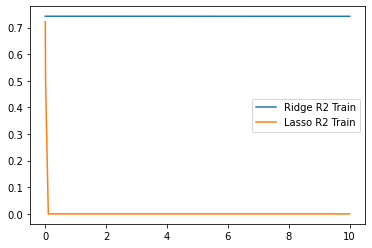

In [ ]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]

# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    
    # # 이전처럼 'k-fold학습'을 쓰지 않고, 그냥 학습
    # ridge_model.fit(train_X,train_y)
    # lasso_model.fit(train_X,train_y)
    # #테스트; sklearn.metrics에 있는 r2_score()함수를 가져와 평가
    # ridge_r2_list_test.append(r2_score(test_y,ridge_model.predict(test_X)))
    # lasso_r2_list_test.append(r2_score(test_y,lasso_model.predict(test_X)))


    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [ ]:
# 각각 alpha = 0.001, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=0.001) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=0.001)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# RMSE; mean_squared_error
print("RMSE for Ridge model : {:.5f}".format(np.sqrt(mean_squared_error(test_y, ridge.predict(test_X)))))
print("RMSE for Lasso model : {:.5f}".format(np.sqrt(mean_squared_error(test_y, lasso.predict(test_X)))))

R square score for Ridge model : 0.74507
R square score for Lasso model : 0.72807
RMSE for Ridge model : 0.10721
RMSE for Lasso model : 0.11072


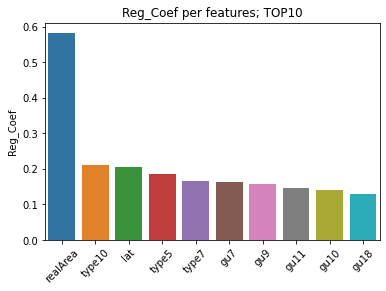

In [ ]:
# 표준화한 회귀계수의 절댓값
coef = ridge.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = data.drop(columns = 'deposit').head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

###standard 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler

total_data = data.iloc[:, :4]

scaler = StandardScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df = pd.concat([trans_data_df.reset_index(drop=True), data.iloc[:, 4:].reset_index(drop=True)], axis = 1)
trans_data_df # 표준화된 값들을 가짐을 확인할 수 있다.

,lat,floor,realArea,deposit,gu1,gu2,gu3,gu4,gu5,gu6,...,type5,type6,type7,type8,type9,type10,direction1,direction2,direction3,direction4
0,2.053087,-0.301195,0.077438,-0.337963,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1.685953,1.729497,2.173250,1.271663,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1.852466,-0.301195,0.863368,-0.400676,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1.810942,1.932566,0.863368,0.393685,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1.527362,-0.707333,-0.970467,-1.236846,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27428,-0.856051,-0.910403,-0.783341,2.525917,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
27429,-0.913366,-0.301195,-1.269869,-0.860569,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
27430,-1.322386,-1.113472,-1.456995,0.644536,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27431,-1.199833,1.932566,-1.382145,-0.965091,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(trans_data_df.drop(columns = 'deposit'), trans_data_df['deposit'], train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(21946, 42) (5487, 42) (21946,) (5487,)


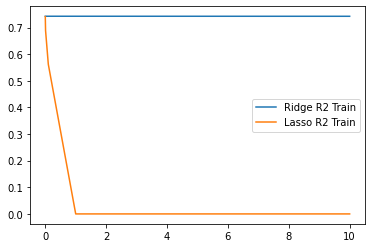

In [ ]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]

# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    
    # # 이전처럼 'k-fold학습'을 쓰지 않고, 그냥 학습
    # ridge_model.fit(train_X,train_y)
    # lasso_model.fit(train_X,train_y)
    # #테스트; sklearn.metrics에 있는 r2_score()함수를 가져와 평가
    # ridge_r2_list_test.append(r2_score(test_y,ridge_model.predict(test_X)))
    # lasso_r2_list_test.append(r2_score(test_y,lasso_model.predict(test_X)))


    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [ ]:
# 각각 alpha = 0.001, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=0.001) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=0.001)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

# 모델 평가
# R^2; r2_score
# 여기서 매우 조심해야할 사항이 있다.
# 그것은 바로 r2_score()와 mean_squared_error() 모두 인자의 순서를 주의해서 넣어주어야한다는 것이다.
# 모두 (정닶값,예측값) 순으로 넣어주어야한다.
# mse는 어차피 같은 값이 나오지만, r2_score는 조심해야한다.
print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y, ridge.predict(test_X))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y, lasso.predict(test_X))))

R square score for Ridge model : 0.74507
R square score for Lasso model : 0.74429
MSE for Ridge model : 0.25449
MSE for Lasso model : 0.25526


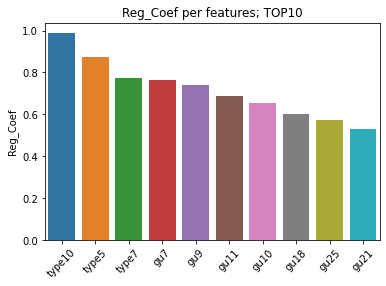

In [ ]:
# 표준화한 회귀계수의 절댓값
coef = ridge.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = data.drop(columns = 'deposit').head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

#2 이론 문제

(직접 종이나 아이패드에 써서 코랩에 이미지 파일로 업로드 해주시면 됩니다)

**1.SVM의 수리적 모델링에서, 목적함수를 적고 증명과정을 서술하시오**
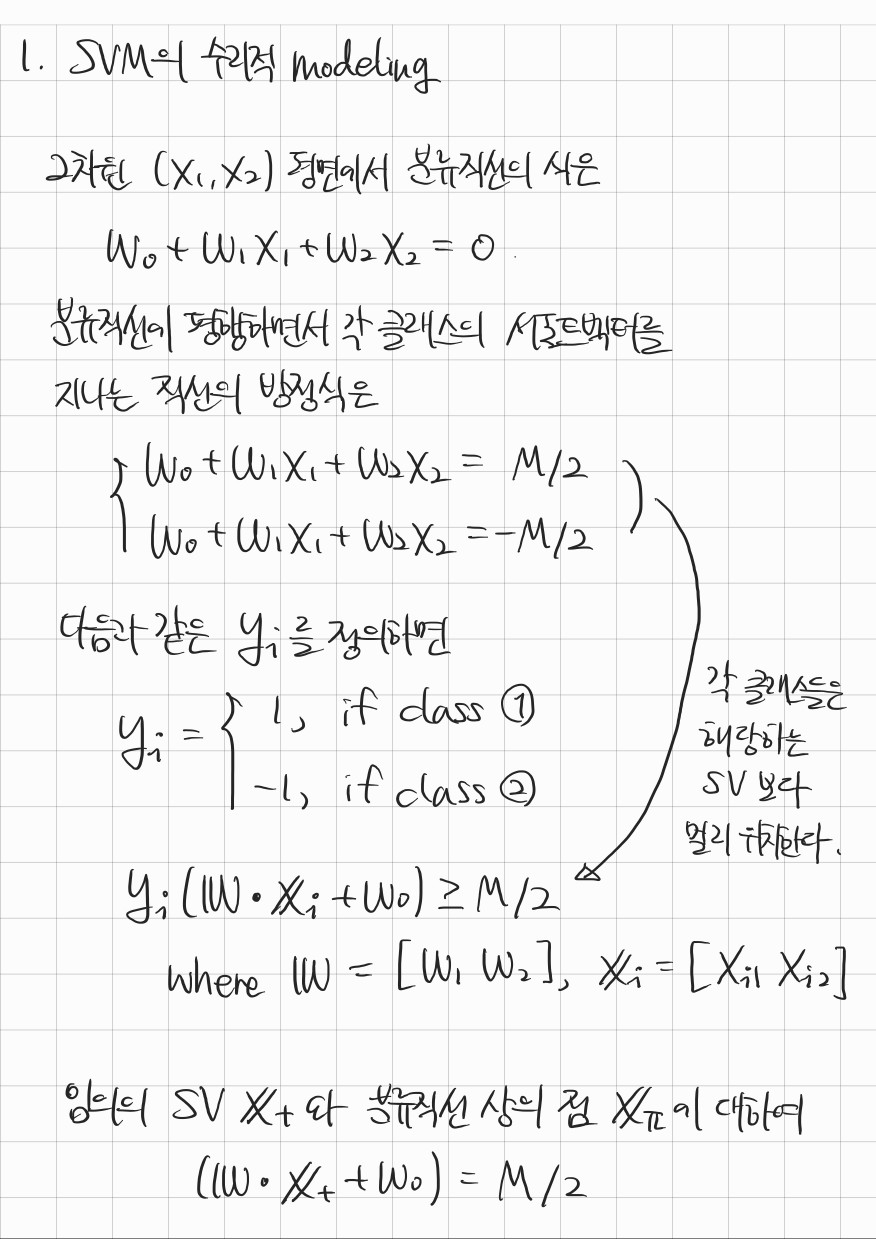

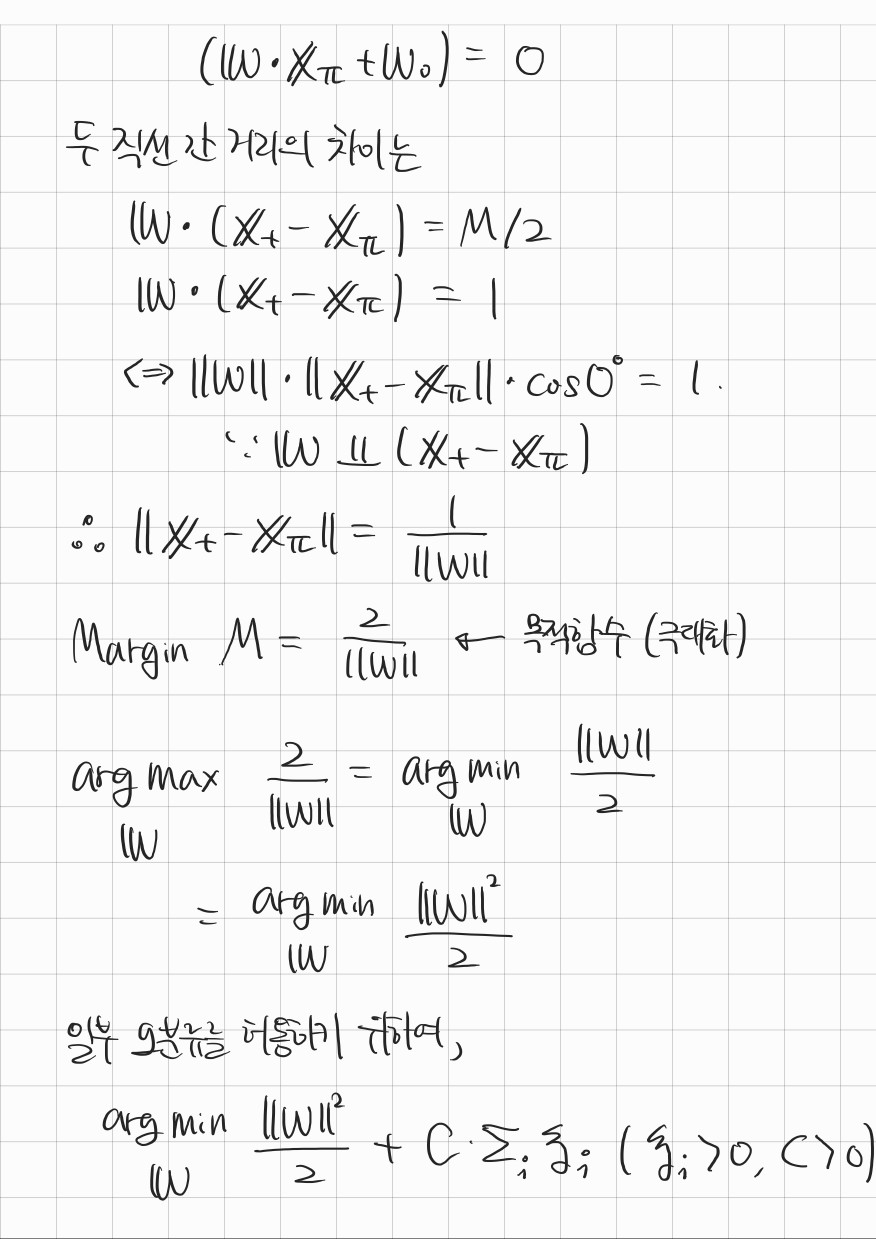

**2. 시그모이드 함수의 공식, 정의역, 치역을 작성하시오**

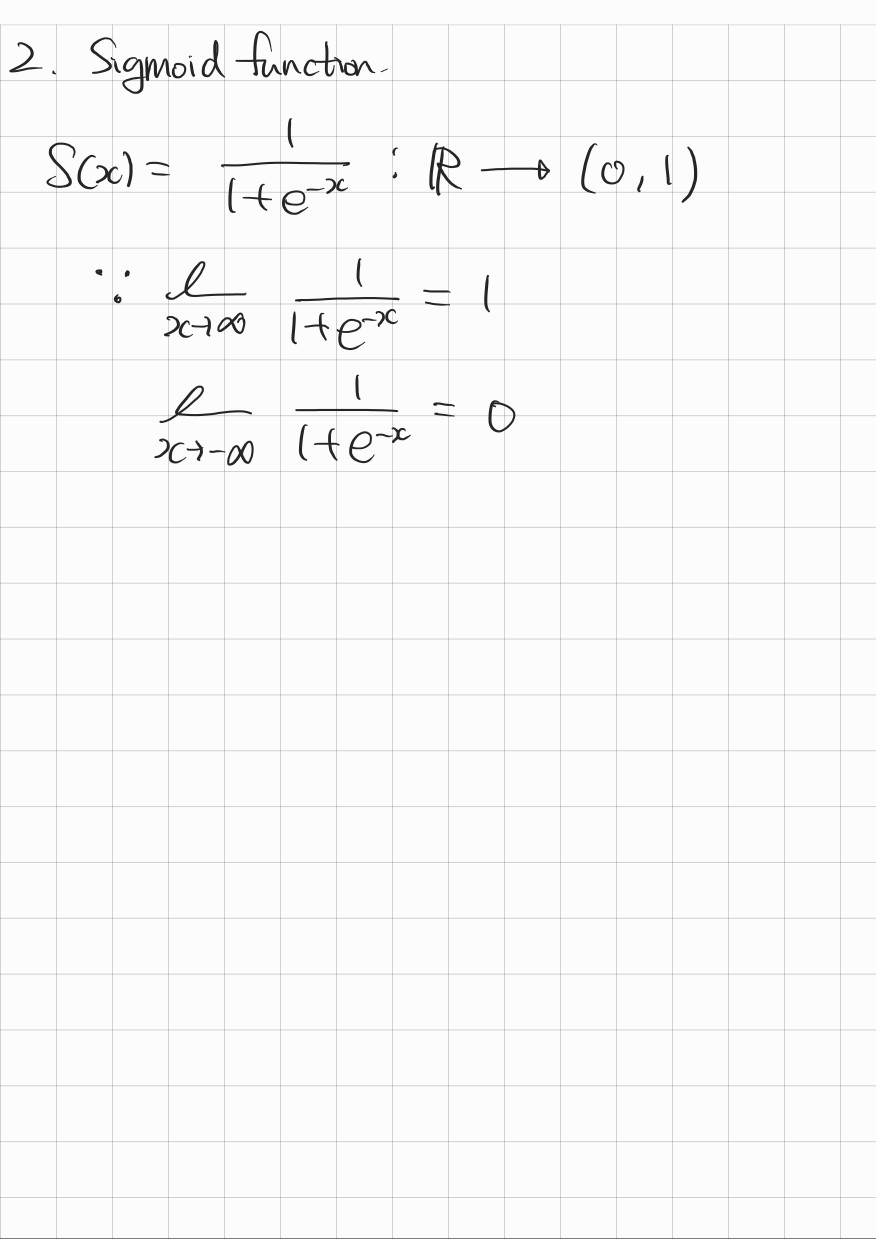

**3. 코드 실습 영상을 참고하여, 아래 그림과 같은 데이터의 F1-score를 계산하시오**


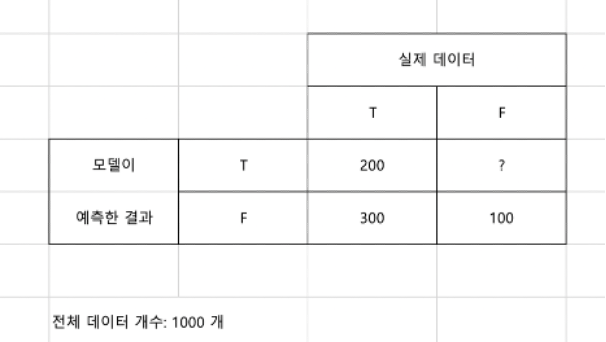

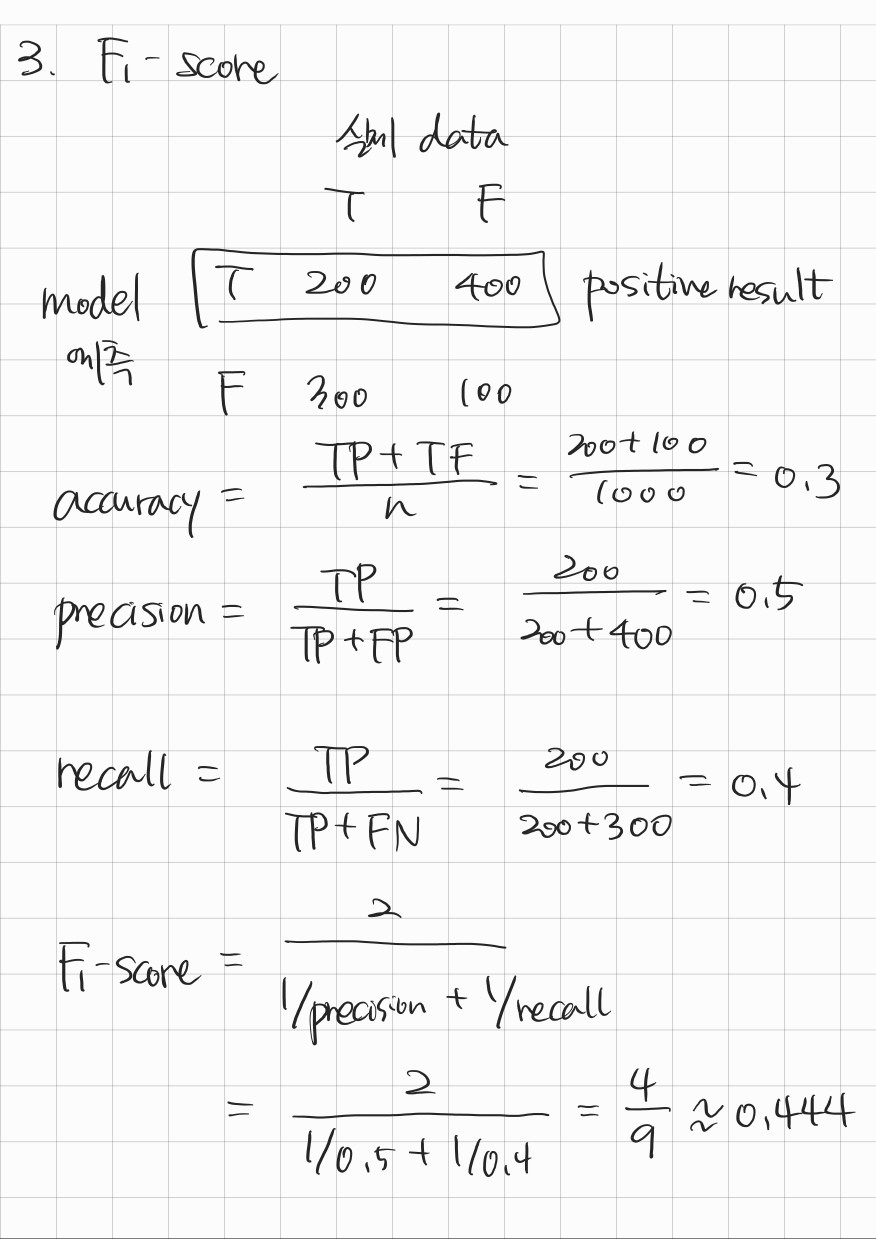